In [102]:
import geopandas as gdp
import pandas as pd
import numpy as np
import re
from shapely.geometry import Point
import re
from pathlib import Path
import matplotlib.pyplot as plt
import contextily as ctx


DATA_DIR = 'Data/'

def get_offsets(header_lines):
    
    # Get offsets and decays depending on the component
    offset_pattern = re.compile(r"#\s*(\*?)\s*offset\s+\d+:?\s+([-\d.]+)\s+\+/\-\s+([-\d.]+)\s+mm.*?\((\d{4}-\d{2}-\d{2}).*?\)")
    ps_decay_pattern = re.compile(r"#\s*!?\s*ps decay\s+\d+:?\s+([-\d.]+)\s+\+/\-\s+([-\d.]+)\s+mm.*?tau:\s+(\d+)\s+days.*?\((\d{4}-\d{2}-\d{2}).*?\)")
    component_pattern = re.compile(r"#\s+([neu])\s+component")

    # Initialize storage
    components = {'n': {'offsets': [], 'ps_decays': []}, 'e': {'offsets': [], 'ps_decays': []}, 'u': {'offsets': [], 'ps_decays': []}}
    current_component = None

    # Process the lines
    for line in header_lines:
        # Check for component
        comp_match = component_pattern.match(line)
        if comp_match:
            current_component = comp_match.group(1)
            continue

        # Check for offset
        offset_match = offset_pattern.match(line)
        if offset_match and current_component:
            coseismic = bool(offset_match.group(1))  # True if * present, meaning coseismic
            offset_value = float(offset_match.group(2))
            offset_error = float(offset_match.group(3))
            offset_date = offset_match.group(4)
            components[current_component]['offsets'].append({
                'value': offset_value,
                'error': offset_error,
                'date': offset_date,
                'coseismic': coseismic
            })

        # Check for ps decay
        ps_decay_match = ps_decay_pattern.match(line)
        if ps_decay_match and current_component:
            decay_value = float(ps_decay_match.group(1))
            decay_error = float(ps_decay_match.group(2))
            tau = int(ps_decay_match.group(3))
            decay_date = ps_decay_match.group(4)
            components[current_component]['ps_decays'].append({
                'value': decay_value,
                'error': decay_error,
                'tau': tau,
                'date': decay_date
            })
            
    return components

def read_file(filename):
    
    with open(DATA_DIR+filename, 'r') as file:
        lines = file.readlines()

    header_lines = [line for line in lines if line.startswith('#')]
    if header_lines:
        column_names = re.split(r'\s{2,}', header_lines[-1].lstrip('#').strip())
    else:
        column_names = []
        
    data_lines = []
    for line in lines:
        if not line.startswith('#'):
            # Split the line by whitespace and handle the missing values
            parts = line.strip().split()
            # Check if the number of parts matches the expected number of columns
            if len(parts) < len(column_names):
                # Add None for missing values
                parts.extend([None] * (len(column_names) - len(parts)))
            data_lines.append(parts)

    # Create a DataFrame from the processed data
    data = pd.DataFrame(data_lines)

    # Assign the extracted column names
    data.columns = column_names
    
    # Extracts latitude, longitude and height
    pattern = r'Latitude\(DD\)\s*:\s*(-?\d+\.\d+)|East Longitude\(DD\)\s*:\s*(-?\d+\.\d+)|Height\s*\(M\)\s*:\s*(-?\d+\.\d+)'
    #referece_pattern = r'Reference_X\s*:\s*(-?\d+\.\d+)|Reference_Y\s*:\s*(-?\d+\.\d+)|Reference_Z\s*:\s*(-?\d+\.\d+)'
    matches = re.findall(pattern, ' '.join(header_lines))
    geom = Point(float(matches[1][1]), float(matches[0][0]))
    
    offsets = get_offsets(header_lines)

    data['Date'] = pd.to_datetime(data['Yr'].astype(str) + data['DayOfYr'].astype(str), format='%Y%j')
    data.set_index('Date', inplace=True)
    #data['Geometry'] = geom
    #gdf = gdp.GeoDataFrame(data, geometry='Geometry')
    data.drop(['Dec Yr', 'Yr', 'DayOfYr'], axis=1, inplace=True)
    #gdf.set_crs(epsg=4326, inplace=True)
    cols = ['N', 'E', 'U', 'N sig', 'E sig', 'U sig', 'CorrNE', 'CorrNU', 'CorrEU']
    data[cols] = data[cols].astype(float)
    
    # Add constant attributes
    data.name = filename.replace("RawTrend.neu", "")
    data.attrs['geometry'] = geom
    data.attrs['height'] = float(matches[2][2])
    data.attrs['offsets'] = offsets
    
    return data

In [97]:
def organize_files():
    gdfs = []
    dir = Path(DATA_DIR)
    for file_path in dir.iterdir():
        if file_path.is_file():
            gdfs.append(read_file(file_path.name))
    return gdfs

In [136]:
def plot_time_series(df, cols, titles, xlabel='Date', ylabel='Data'):
    axs = df[cols].plot(subplots=True, layout=(1, 3), figsize=(15, 5), legend=False, style='o', ylabel=ylabel, xlabel=xlabel, color='b').flatten()
    for ind, ax in enumerate(axs): 
        ax.set_title(f'Station: {df.name}\n{titles[ind]}')
        
    components = ['n', 'e', 'u']
    offsets = df.attrs['offsets']

    for i, component in enumerate(components):
        # Get the offsets and decays for the current component
        comp_offsets = offsets[component]['offsets']
        comp_decays = offsets[component].get('ps_decays', [])  # Handle decays if present
        
        # Plot offsets
        for offset in comp_offsets:
            color = 'r' if offset['coseismic'] else 'g'
            axs[i].axvline(x=offset['date'], color=color, linestyle='-', label='Offset' if i == 0 else "")
        
        # Plot decays
        for decay in comp_decays:
            axs[i].axvline(x=decay['date'], color='y', linestyle='--', label='Decay' if i == 0 else "")
        plt.tight_layout()
        plt.show()

In [99]:
def get_geometries(dfs):
    return gdp.GeoDataFrame(geometry=[df.attrs['geometry'] for df in dfs])

In [100]:
def plot_stations(dfs):
    gdf = get_geometries(dfs)
    gdf.set_crs(epsg=4326, inplace=True)
    gdf.to_crs(epsg=3857, inplace=True)
    ax = gdf.plot(marker='o', color='red', markersize=10, figsize=(20, 20))
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    plt.show()

In [147]:
dfs[179].attrs['offsets']

{'n': {'offsets': [{'value': -47.24,
    'error': 0.13,
    'date': '2009-04-06',
    'coseismic': True},
   {'value': -3.89, 'error': 0.71, 'date': '2016-10-27', 'coseismic': True},
   {'value': -0.71, 'error': 0.72, 'date': '2016-10-30', 'coseismic': True},
   {'value': -0.03, 'error': 0.11, 'date': '2017-11-24', 'coseismic': False},
   {'value': 0.02, 'error': 0.11, 'date': '2018-08-03', 'coseismic': False}],
  'ps_decays': []},
 'e': {'offsets': [{'value': 8.68,
    'error': 0.14,
    'date': '2009-04-06',
    'coseismic': True},
   {'value': -2.62, 'error': 0.71, 'date': '2016-10-27', 'coseismic': True},
   {'value': -3.15, 'error': 0.72, 'date': '2016-10-30', 'coseismic': True},
   {'value': -0.04, 'error': 0.12, 'date': '2017-11-24', 'coseismic': False},
   {'value': 0.03, 'error': 0.11, 'date': '2018-08-03', 'coseismic': False}],
  'ps_decays': []},
 'u': {'offsets': [{'value': -74.43,
    'error': 0.32,
    'date': '2009-04-06',
    'coseismic': True},
   {'value': -0.33, 'err

In [103]:
dfs = organize_files()

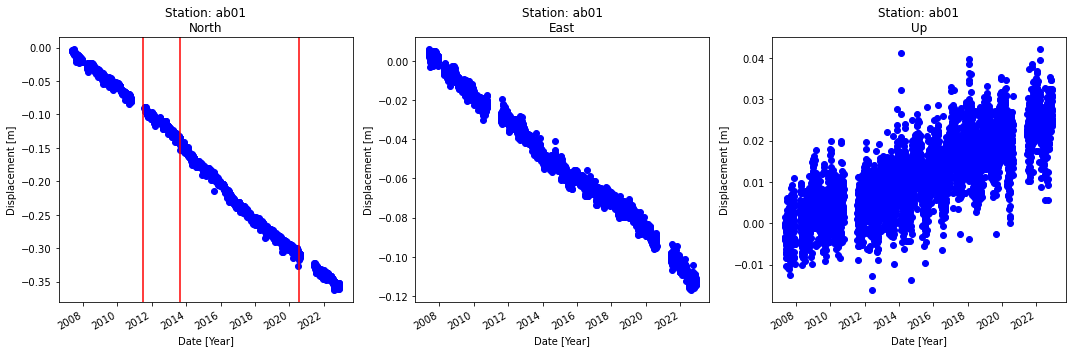

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

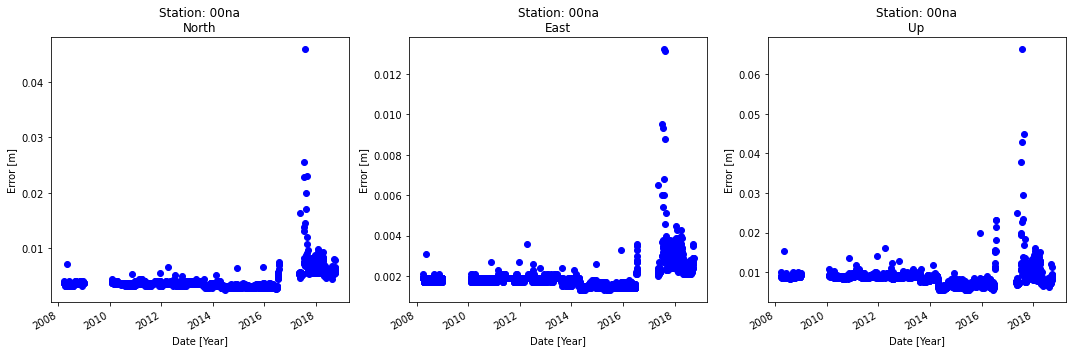

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

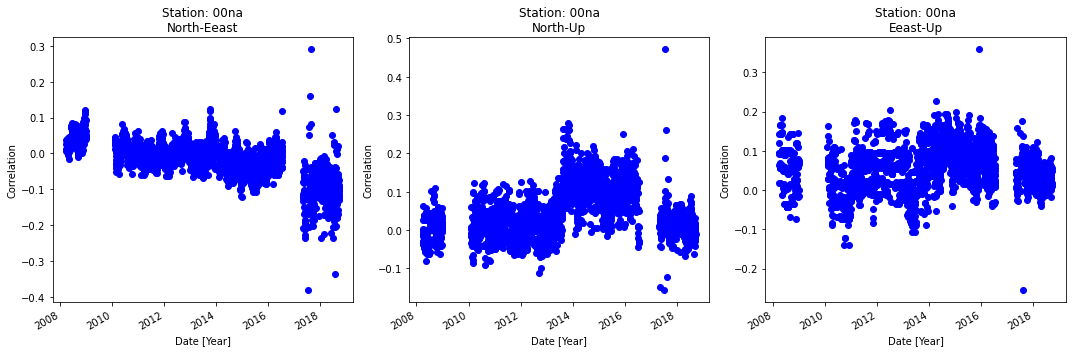

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [137]:
plot_time_series(dfs[5], ['N', 'E', 'U'], titles=['North', 'East', 'Up'], ylabel='Displacement [m]', xlabel='Date [Year]')
plot_time_series(dfs[0], ['N sig', 'E sig', 'U sig'], titles=['North', 'East', 'Up'], ylabel='Error [m]', xlabel='Date [Year]')
plot_time_series(dfs[0], ['CorrNE', 'CorrNU', 'CorrEU'], titles=['North-Eeast', 'North-Up', 'Eeast-Up'], ylabel='Correlation', xlabel='Date [Year]')

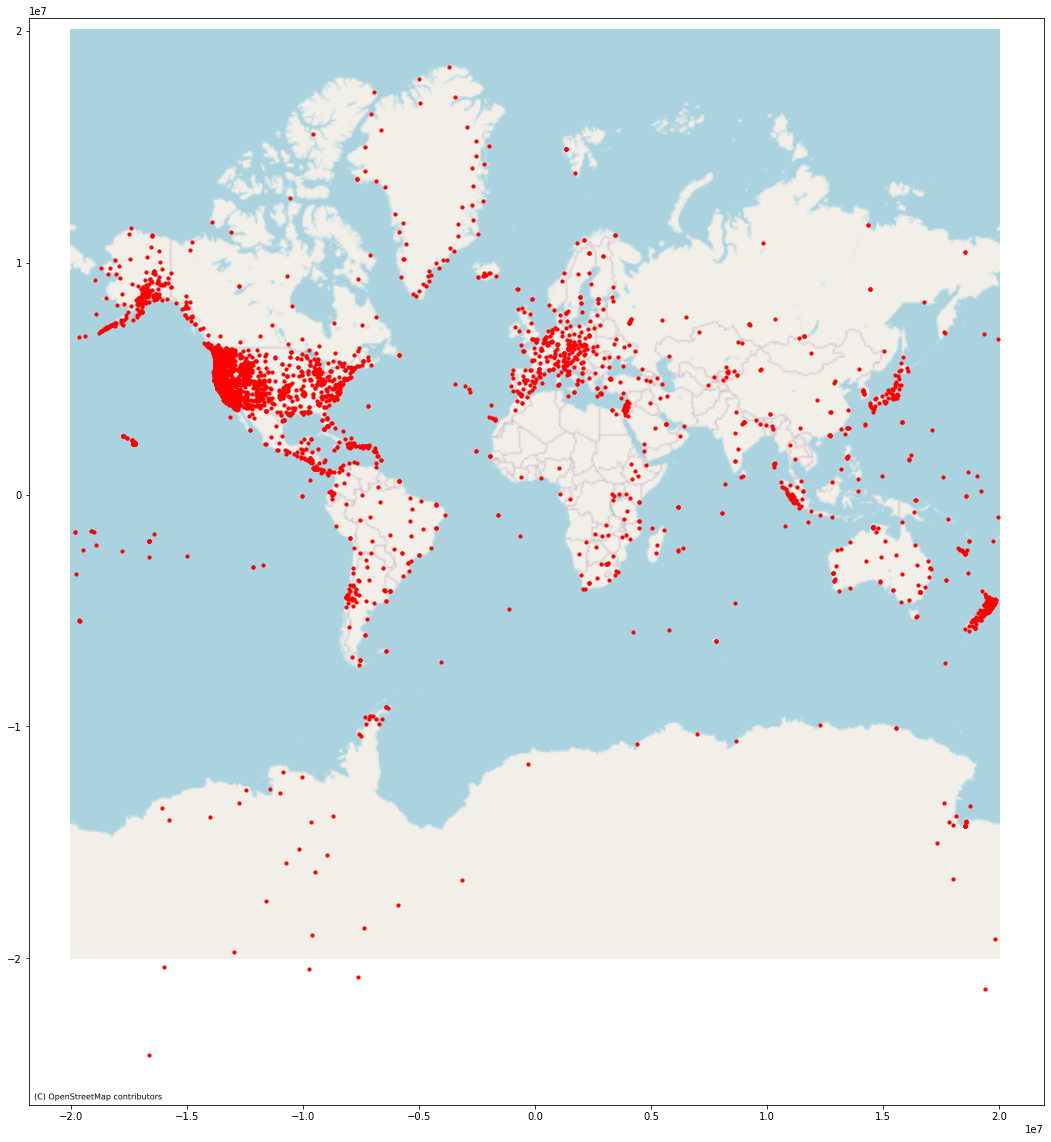

In [108]:
plot_stations(dfs)